In [50]:
import pandas as pd
from ydata_profiling import ProfileReport
import numpy as np
import string
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, accuracy_score, classification_report, confusion_matrix


import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [51]:
df = pd.read_csv("dataproject2025.csv", index_col=0)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1086236 entries, 0 to 1086682
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   issue_d                  1086236 non-null  int64  
 1   loan duration            1086236 non-null  int64  
 2   annual_inc               1086236 non-null  float64
 3   avg_cur_bal              1086236 non-null  float64
 4   bc_open_to_buy           1086236 non-null  float64
 5   bc_util                  1086236 non-null  float64
 6   delinq_2yrs              1086236 non-null  float64
 7   dti                      1086236 non-null  float64
 8   emp_length               1086236 non-null  object 
 9   emp_title                1086236 non-null  object 
 10  fico_range_high          1086236 non-null  float64
 11  funded_amnt              1086236 non-null  float64
 12  grade                    1086236 non-null  object 
 13  home_ownership           1086236 non-null  obje

In [53]:
df.drop(columns=['Predictions', 'Predicted probabilities'], inplace=True)

In [54]:
df.head()

,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,emp_length,emp_title,...,pub_rec,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,target,tax_liens,zip_code,Pct_afro_american
0,2013,0,39600.0,1379.0,21564.0,16.1,0.0,2.49,2 years,other,...,0.0,0.0,home_improvement,4136.0,16.1,B2,0,0.0,782,7.388592
1,2013,0,55000.0,9570.0,16473.0,53.9,0.0,22.87,10+ years,other,...,0.0,0.0,debt_consolidation,36638.0,61.2,B2,0,0.0,481,9.745456
2,2013,0,325000.0,53306.0,13901.0,67.1,0.0,18.55,5 years,sales manager,...,0.0,0.0,debt_consolidation,29581.0,54.6,A3,0,0.0,945,7.542862
3,2013,0,130000.0,36362.0,3567.0,93.0,0.0,13.03,10+ years,other,...,0.0,0.0,debt_consolidation,10805.0,67.0,B3,0,0.0,809,6.598132
4,2013,1,73000.0,24161.0,4853.0,74.7,1.0,23.13,6 years,other,...,0.0,0.0,debt_consolidation,27003.0,82.8,D5,1,0.0,802,7.058900


In [55]:
df.isna().sum()

issue_d                  0
loan duration            0
annual_inc               0
avg_cur_bal              0
bc_open_to_buy           0
bc_util                  0
delinq_2yrs              0
dti                      0
emp_length               0
emp_title                0
fico_range_high          0
funded_amnt              0
grade                    0
home_ownership           0
inq_last_6mths           0
int_rate                 0
mo_sin_old_rev_tl_op     0
mo_sin_rcnt_rev_tl_op    0
mo_sin_rcnt_tl           0
mort_acc                 0
mths_since_recent_bc     0
num_actv_bc_tl           0
num_bc_tl                0
num_il_tl                0
num_rev_accts            0
open_acc                 0
pub_rec                  0
pub_rec_bankruptcies     0
purpose                  0
revol_bal                0
revol_util               0
sub_grade                0
target                   0
tax_liens                0
zip_code                 0
Pct_afro_american        0
dtype: int64

In [56]:
na_rows = df.isna().any(axis=1)
print(f"Number of rows with NA: {na_rows.sum()}")
display(df[na_rows])

print(df.isna().sum(axis=1).value_counts())

Number of rows with NA: 0


,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,emp_length,emp_title,...,pub_rec,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,target,tax_liens,zip_code,Pct_afro_american


0    1086236
Name: count, dtype: int64


In [57]:
# ProfileReport(df)

In [58]:
df_dropped = df.dropna(axis=0) # either y misses or all X miss

In [59]:
def get_features(df: pd.DataFrame()) -> pd.DataFrame():
    """
    Get additional features.
    """        

    df_with_features = (
        df
        .assign(

            # logs --> to money, not months or so
            annual_inc_log = np.log1p(df["annual_inc"]),
            avg_cur_bal_log = np.log1p(df["avg_cur_bal"]),
            fico_range_high_log = np.log1p(df["fico_range_high"]),
            revol_bal_log = np.log1p(df["revol_bal"]),

            # broader zip code area
            zip_code2 = np.round(df["zip_code"] / 10, 0),

            # total balance?
            cur_balance = df["avg_cur_bal"] * df["open_acc"],

            # flags
            delinq_2yrs_flag = df["delinq_2yrs"] >= 1,
            tax_liens_flag = df["tax_liens"] >= 1,

            # shares
            s_actv_bc_tl = df["num_actv_bc_tl"] / (df["open_acc"] + 1e-6),
            s_bc_tl = df["num_bc_tl"] / (df["open_acc"] + 1e-6),
            s_il_tl = df["num_il_tl"] / (df["open_acc"] + 1e-6),
            s_rev_accts = df["num_rev_accts"] / (df["open_acc"] + 1e-6),

            # interactions
            int_rate_x_duration = df["int_rate"] * df["loan duration"], # higher rates are even riskier on 60 vs 36
            dti_x_util = df["dti"] * (df["revol_util"] / 100.0), # debt burden (DTI) is more problematic if utilization of their cards/lines is also high
            revol_bal_income_ratio = df["revol_bal"] / (df["annual_inc"] + 1e-6), # leverage: outstanding revolving balance / income
            fico_x_dti = df["fico_range_high"] * df["dti"], # same DTI can mean different risk depending on FICO score; "do they manage well or not?"
        )
    )

    return df_with_features

df_engineered = get_features(df_dropped)

In [60]:
def categorical_encoding(df: pd.DataFrame) -> pd.DataFrame:
  """Encodings of categorical variables."""

  df_encoded = df.copy()

  # grade to numeric
  grade_map = {c: i+1 for i, c in enumerate(string.ascii_uppercase[:7])}
  df_encoded["grade_num"] = df_encoded["grade"].map(grade_map)

  # sub_grade to numeric
  sg = df_encoded["sub_grade"].astype(str).str.upper().str.strip()
  letter = sg.str[0]
  number = pd.to_numeric(sg.str[1:].str.extract(r"(\d+)", expand=False), errors="coerce")
  letter_map = {ch: i+1 for i, ch in enumerate("ABCDEFG")}
  base = letter.map(letter_map)
  sub_grade_num = (base - 1) * 5 + number
  df_encoded["sub_grade_num"] = sub_grade_num.astype("float32")

  # emp_length to numeric; map prob cleanest; maybe 10+ different?
  emp_length_map = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
  }

  df_encoded["emp_length_num"] = df_encoded["emp_length"].map(emp_length_map).astype("float32")

  # one-hot
  onehot_cols = ["home_ownership", "purpose", "emp_title"]
  df_encoded = pd.get_dummies(df_encoded, columns=onehot_cols, prefix=onehot_cols, drop_first=True)

  # drop originals
  df_encoded = df_encoded.drop(columns=["grade", "sub_grade", "emp_length"])

  return df_encoded

df_encoded = categorical_encoding(df_engineered)

## STEP 2

In [61]:
target_col = 'target'
# Separate features and target
X = df_encoded.drop(columns=[target_col])
y = df_encoded[target_col]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Target distribution in training set:")
print(y_train.value_counts(normalize=True))
print("\n" + "="*50 + "\n")

# Cross-validation setup
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

print("XGBOOST MODEL")
print("="*50)

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    verbosity=0
)

# Cross-validation for XGBoost
print("Performing cross-validation...")
xgb_cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='accuracy')

print(f"XGBoost CV Scores: {xgb_cv_scores}")
print(f"XGBoost CV Mean: {xgb_cv_scores.mean():.4f} (+/- {xgb_cv_scores.std() * 2:.4f})")

# Train XGBoost on full training set
print("Training XGBoost on full training set...")
xgb_model.fit(X_train, y_train)

# Predictions
xgb_train_pred = xgb_model.predict(X_train)
xgb_test_pred = xgb_model.predict(X_test)

# Evaluate XGBoost
xgb_train_acc = accuracy_score(y_train, xgb_train_pred)
xgb_test_acc = accuracy_score(y_test, xgb_test_pred)

print(f"XGBoost Training Accuracy: {xgb_train_acc:.4f}")
print(f"XGBoost Test Accuracy: {xgb_test_acc:.4f}")

print("\nXGBoost Classification Report (Test Set):")
print(classification_report(y_test, xgb_test_pred))


# # Plot confusion matrices
# plt.subplot(2, 2, 2)
# xgb_cm = confusion_matrix(y_test, xgb_test_pred)
# sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Blues')
# plt.title('XGBoost Confusion Matrix')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')

# # Feature importance comparison (top 10 features)
# plt.subplot(2, 2, 4)
# xgb_importance = xgb_model.feature_importances_
# rf_importance = rf_model.feature_importances_

# # Get top 10 features from XGBoost
# top_features_idx = np.argsort(xgb_importance)[-10:]
# top_features = X.columns[top_features_idx]

# x_pos = np.arange(len(top_features))
# plt.barh(x_pos - 0.2, xgb_importance[top_features_idx], 0.4, label='XGBoost', alpha=0.8)
# plt.barh(x_pos + 0.2, rf_importance[top_features_idx], 0.4, label='Random Forest', alpha=0.8)
# plt.yticks(x_pos, top_features)
# plt.xlabel('Feature Importance')
# plt.title('Top 10 Feature Importance Comparison')
# plt.legend()

# plt.tight_layout()
# plt.show()


Training set size: (868988, 112)
Test set size: (217248, 112)
Target distribution in training set:
target
0    0.789505
1    0.210495
Name: proportion, dtype: float64


XGBOOST MODEL
Performing cross-validation...
XGBoost CV Scores: [0.7951378  0.79462341 0.79401855]
XGBoost CV Mean: 0.7946 (+/- 0.0009)
Training XGBoost on full training set...
XGBoost Training Accuracy: 0.8007
XGBoost Test Accuracy: 0.7945

XGBoost Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.80      0.98      0.88    171518
           1       0.56      0.11      0.18     45730

    accuracy                           0.79    217248
   macro avg       0.68      0.54      0.53    217248
weighted avg       0.75      0.79      0.74    217248



In [62]:
import optuna
from sklearn.model_selection import cross_val_score
import xgboost as xgb

# Define the objective function for Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42,
        'eval_metric': 'logloss',
        'verbosity': 0
    }
    
    # Create model with suggested parameters
    model = xgb.XGBClassifier(**params)
    
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    
    # Return mean CV score (Optuna maximizes this)
    return cv_scores.mean()

study = optuna.create_study(direction='maximize', study_name='xgboost_optimization')
study.optimize(objective, n_trials=10)

# Get best parameters
best_params = study.best_params
print(f"\nBest parameters: {best_params}")
print(f"Best CV score: {study.best_value:.4f}")

# Train final model with best parameters
print("\nTraining final optimized XGBoost model...")
optimized_xgb = xgb.XGBClassifier(**best_params)
optimized_xgb.fit(X_train, y_train)

# Evaluate optimized model
optimized_train_pred = optimized_xgb.predict(X_train)
optimized_test_pred = optimized_xgb.predict(X_test)

optimized_train_acc = accuracy_score(y_train, optimized_train_pred)
optimized_test_acc = accuracy_score(y_test, optimized_test_pred)

print(f"Optimized XGBoost Training Accuracy: {optimized_train_acc:.4f}")
print(f"Optimized XGBoost Test Accuracy: {optimized_test_acc:.4f}")

print("\nOptimized XGBoost Classification Report (Test Set):")
print(classification_report(y_test, optimized_test_pred))



[I 2025-09-24 11:44:27,256] A new study created in memory with name: xgboost_optimization
[I 2025-09-24 11:44:35,118] Trial 0 finished with value: 0.7952629954077405 and parameters: {'n_estimators': 142, 'max_depth': 7, 'learning_rate': 0.12929053536600374, 'subsample': 0.994954938227667, 'colsample_bytree': 0.8601551662067397, 'colsample_bylevel': 0.6750899104315126, 'reg_alpha': 5.934257461844218e-08, 'reg_lambda': 1.6798138946482606e-05, 'min_child_weight': 8}. Best is trial 0 with value: 0.7952629954077405.
[I 2025-09-24 11:44:40,475] Trial 1 finished with value: 0.7895045731377385 and parameters: {'n_estimators': 117, 'max_depth': 3, 'learning_rate': 0.018773237847509172, 'subsample': 0.6900968087991431, 'colsample_bytree': 0.8978890034901077, 'colsample_bylevel': 0.7304016966131155, 'reg_alpha': 3.1650968644897985e-06, 'reg_lambda': 4.451861695542843e-06, 'min_child_weight': 10}. Best is trial 0 with value: 0.7952629954077405.
[I 2025-09-24 11:44:50,916] Trial 2 finished with val


Best parameters: {'n_estimators': 142, 'max_depth': 7, 'learning_rate': 0.12929053536600374, 'subsample': 0.994954938227667, 'colsample_bytree': 0.8601551662067397, 'colsample_bylevel': 0.6750899104315126, 'reg_alpha': 5.934257461844218e-08, 'reg_lambda': 1.6798138946482606e-05, 'min_child_weight': 8}
Best CV score: 0.7953

Training final optimized XGBoost model...
Optimized XGBoost Training Accuracy: 0.8004
Optimized XGBoost Test Accuracy: 0.7944

Optimized XGBoost Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.80      0.98      0.88    171518
           1       0.56      0.10      0.17     45730

    accuracy                           0.79    217248
   macro avg       0.68      0.54      0.53    217248
weighted avg       0.75      0.79      0.73    217248



In [63]:

# Save the optimized model
joblib.dump(optimized_xgb, 'optimized_xgb_model.pkl')

print("Optimized XGBoost model saved as 'optimized_xgb_model.pkl'")


Optimized XGBoost model saved as 'optimized_xgb_model.pkl'


In [64]:
# To load the optimized model:
# optimized_xgb = joblib.load('optimized_xgb_model.pkl')


In [65]:
xgb_model = joblib.load('optimized_xgb_model.pkl')

## STEP 3

In [66]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Evaluate model performance on test set
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
y_pred = xgb_model.predict(X_test)

# Basic performance metrics
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc_score:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.7944
Test AUC: 0.7221

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.98      0.88    171518
           1       0.56      0.10      0.17     45730

    accuracy                           0.79    217248
   macro avg       0.68      0.54      0.53    217248
weighted avg       0.75      0.79      0.73    217248



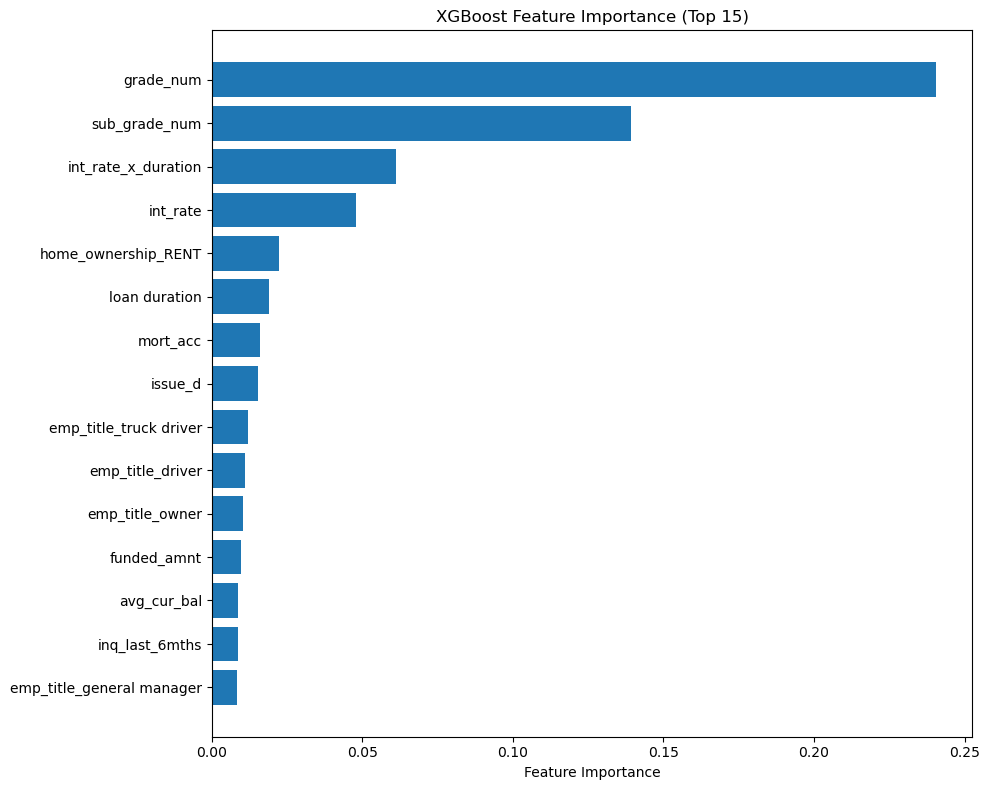

Top 10 Most Important Features:
1. grade_num: 0.2406
2. sub_grade_num: 0.1392
3. int_rate_x_duration: 0.0611
4. int_rate: 0.0480
5. home_ownership_RENT: 0.0224
6. loan duration: 0.0192
7. mort_acc: 0.0159
8. issue_d: 0.0153
9. emp_title_truck driver: 0.0121
10. emp_title_driver: 0.0109


In [77]:
# XGBoost feature importance
feature_importance = xgb_model.feature_importances_
feature_names = X.columns

# Create feature importance plot
plt.figure(figsize=(10, 8))
indices = np.argsort(feature_importance)[-15:]  # Top 15 features
plt.barh(range(len(indices)), feature_importance[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance (Top 15)')
plt.tight_layout()
plt.show()

# Print top 10 features
top_features_idx = np.argsort(feature_importance)[-10:][::-1]
print("Top 10 Most Important Features:")
for i, idx in enumerate(top_features_idx):
    print(f"{i+1}. {feature_names[idx]}: {feature_importance[idx]:.4f}")

In [68]:
from sklearn.utils import resample

def compute_feature_importance_stability(model, X, y, n_bootstrap=50):
    """Compute feature importance stability using bootstrap sampling"""
    
    feature_importances = []
    
    for i in range(n_bootstrap):
        # Bootstrap sample
        X_boot, y_boot = resample(X, y, random_state=i)
        
        # Train new model on bootstrap sample
        boot_model = type(model)(**model.get_params())
        boot_model.fit(X_boot, y_boot)
        
        # Store feature importances
        feature_importances.append(boot_model.feature_importances_)
    
    return np.array(feature_importances)

# Compute stability
stability_matrix = compute_feature_importance_stability(xgb_model, X_train, y_train, n_bootstrap=30)

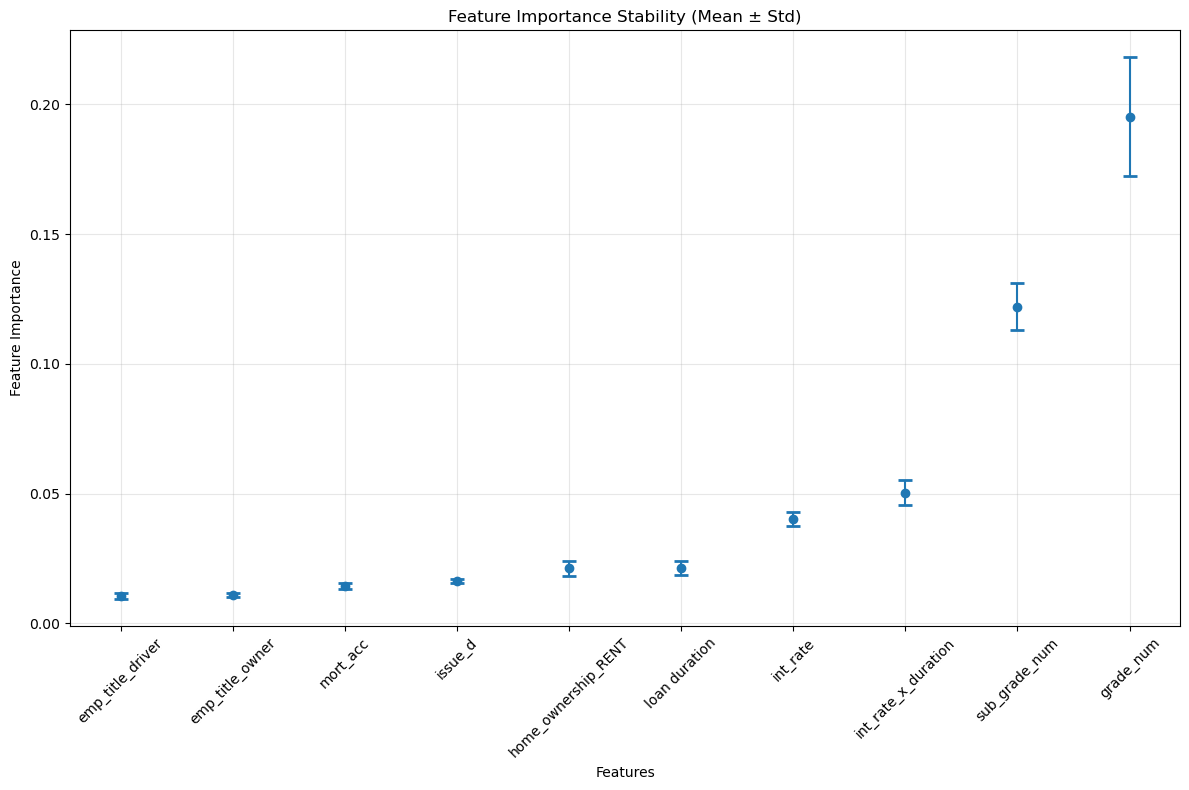

Feature Stability Analysis:
--------------------------------------------------
s_bc_tl: CV = 0.0376 (Mean: 0.0039)
revol_util: CV = 0.0393 (Mean: 0.0040)
bc_open_to_buy: CV = 0.0405 (Mean: 0.0050)
num_bc_tl: CV = 0.0413 (Mean: 0.0040)
annual_inc: CV = 0.0414 (Mean: 0.0055)
mo_sin_old_rev_tl_op: CV = 0.0421 (Mean: 0.0062)
Pct_afro_american: CV = 0.0433 (Mean: 0.0044)
s_rev_accts: CV = 0.0438 (Mean: 0.0046)
emp_length_num: CV = 0.0458 (Mean: 0.0046)
s_actv_bc_tl: CV = 0.0461 (Mean: 0.0041)


In [69]:
# Calculate stability metrics
importance_mean = stability_matrix.mean(axis=0)
importance_std = stability_matrix.std(axis=0)
stability_coefficient = importance_std / (importance_mean + 1e-8)  # Coefficient of variation

# Create stability plot
plt.figure(figsize=(12, 8))
indices = np.argsort(importance_mean)[-10:]  # Top 10 features

plt.errorbar(range(len(indices)), 
             importance_mean[indices], 
             yerr=importance_std[indices],
             fmt='o', capsize=5, capthick=2)

plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45)
plt.ylabel('Feature Importance')
plt.xlabel('Features')
plt.title('Feature Importance Stability (Mean ± Std)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print stability metrics
print("Feature Stability Analysis:")
print("-" * 50)
for i, idx in enumerate(np.argsort(stability_coefficient)[:10]):  # Most stable features
    print(f"{feature_names[idx]}: CV = {stability_coefficient[idx]:.4f} (Mean: {importance_mean[idx]:.4f})")

In [70]:
def compute_performance_stability(model, X, y, n_bootstrap=50):
    """Compute performance stability using bootstrap sampling"""
    
    performance_scores = {'accuracy': [], 'auc': []}
    
    for i in range(n_bootstrap):
        # Bootstrap sample for training
        X_boot, y_boot = resample(X, y, random_state=i)
        
        # Train model
        boot_model = type(model)(**model.get_params())
        boot_model.fit(X_boot, y_boot)
        
        # Create hold-out test set (complement of bootstrap)
        test_indices = list(set(range(len(X))) - set(resample(range(len(X)), random_state=i)))
        if len(test_indices) > 0:
            X_holdout = X.iloc[test_indices]
            y_holdout = y.iloc[test_indices]
            
            # Predict and evaluate
            y_pred = boot_model.predict(X_holdout)
            y_pred_proba = boot_model.predict_proba(X_holdout)[:, 1]
            
            performance_scores['accuracy'].append(accuracy_score(y_holdout, y_pred))
            performance_scores['auc'].append(roc_auc_score(y_holdout, y_pred_proba))
    
    return performance_scores

# Compute performance stability
print("Computing performance stability...")
perf_stability = compute_performance_stability(xgb_model, X_train, y_train, n_bootstrap=30)

Computing performance stability...


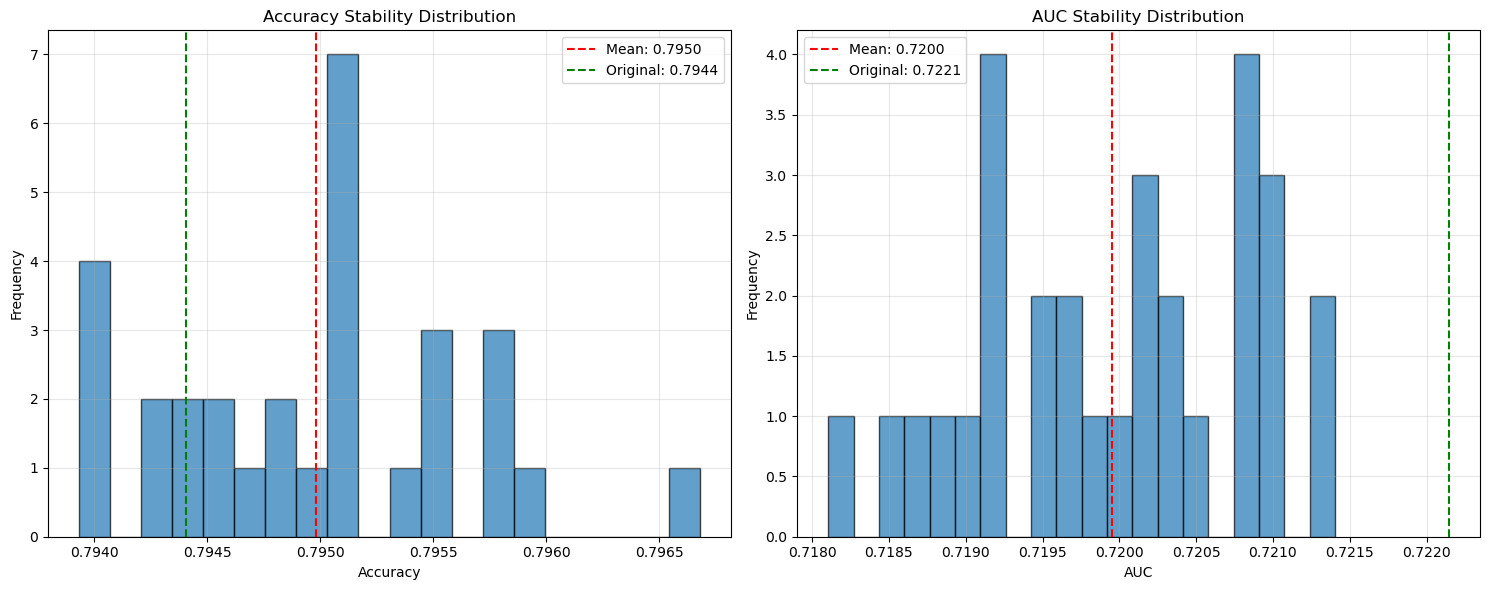

Performance Stability Analysis:
----------------------------------------
Accuracy - Mean: 0.7950, Std: 0.0007
AUC - Mean: 0.7200, Std: 0.0009
Accuracy CV: 0.0008
AUC CV: 0.0012


In [71]:
# Plot performance stability
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy distribution
ax1.hist(perf_stability['accuracy'], bins=20, alpha=0.7, edgecolor='black')
ax1.axvline(np.mean(perf_stability['accuracy']), color='red', linestyle='--', 
           label=f'Mean: {np.mean(perf_stability["accuracy"]):.4f}')
ax1.axvline(accuracy, color='green', linestyle='--', 
           label=f'Original: {accuracy:.4f}')
ax1.set_xlabel('Accuracy')
ax1.set_ylabel('Frequency')
ax1.set_title('Accuracy Stability Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# AUC distribution
ax2.hist(perf_stability['auc'], bins=20, alpha=0.7, edgecolor='black')
ax2.axvline(np.mean(perf_stability['auc']), color='red', linestyle='--',
           label=f'Mean: {np.mean(perf_stability["auc"]):.4f}')
ax2.axvline(auc_score, color='green', linestyle='--',
           label=f'Original: {auc_score:.4f}')
ax2.set_xlabel('AUC')
ax2.set_ylabel('Frequency')
ax2.set_title('AUC Stability Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print stability statistics
print("Performance Stability Analysis:")
print("-" * 40)
print(f"Accuracy - Mean: {np.mean(perf_stability['accuracy']):.4f}, Std: {np.std(perf_stability['accuracy']):.4f}")
print(f"AUC - Mean: {np.mean(perf_stability['auc']):.4f}, Std: {np.std(perf_stability['auc']):.4f}")
print(f"Accuracy CV: {np.std(perf_stability['accuracy'])/np.mean(perf_stability['accuracy']):.4f}")
print(f"AUC CV: {np.std(perf_stability['auc'])/np.mean(perf_stability['auc']):.4f}")

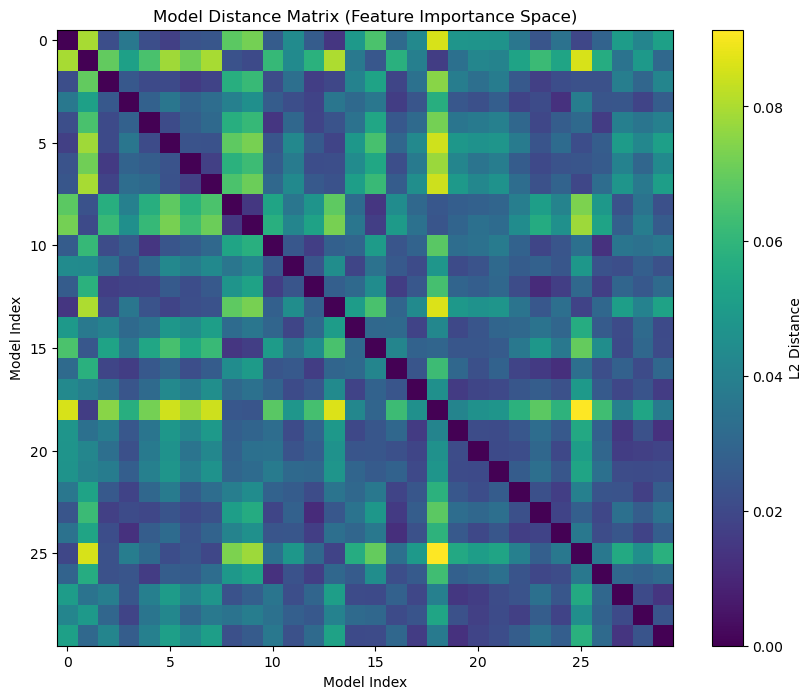

Model Distance Statistics:
Mean distance: 0.0356
Std distance: 0.0162
Max distance: 0.0914
Min distance: 0.0112


In [72]:
def compute_model_distance(model1_importances, model2_importances):
    """Compute L2 distance between two models based on feature importances"""
    return np.sqrt(np.sum((model1_importances - model2_importances)**2))

# Compute pairwise distances between bootstrap models
n_models = len(stability_matrix)
distance_matrix = np.zeros((n_models, n_models))

for i in range(n_models):
    for j in range(i+1, n_models):
        dist = compute_model_distance(stability_matrix[i], stability_matrix[j])
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist

# Visualize distance matrix
plt.figure(figsize=(10, 8))
plt.imshow(distance_matrix, cmap='viridis')
plt.colorbar(label='L2 Distance')
plt.title('Model Distance Matrix (Feature Importance Space)')
plt.xlabel('Model Index')
plt.ylabel('Model Index')
plt.show()

# Print distance statistics
upper_tri = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]
print(f"Model Distance Statistics:")
print(f"Mean distance: {np.mean(upper_tri):.4f}")
print(f"Std distance: {np.std(upper_tri):.4f}")
print(f"Max distance: {np.max(upper_tri):.4f}")
print(f"Min distance: {np.min(upper_tri):.4f}")

In [73]:
    # Create comprehensive stability report
print("="*60)
print("COMPREHENSIVE STABILITY ANALYSIS REPORT")
print("="*60)

print(f"\n1. MODEL PERFORMANCE:")
print(f"   Test Accuracy: {accuracy:.4f}")
print(f"   Test AUC: {auc_score:.4f}")

print(f"\n2. PERFORMANCE STABILITY:")
print(f"   Accuracy CV: {np.std(perf_stability['accuracy'])/np.mean(perf_stability['accuracy']):.4f}")
print(f"   AUC CV: {np.std(perf_stability['auc'])/np.mean(perf_stability['auc']):.4f}")

print(f"\n3. FEATURE IMPORTANCE STABILITY:")
most_stable_idx = np.argmin(stability_coefficient)
least_stable_idx = np.argmax(stability_coefficient)
print(f"   Most stable feature: {feature_names[most_stable_idx]} (CV: {stability_coefficient[most_stable_idx]:.4f})")
print(f"   Least stable feature: {feature_names[least_stable_idx]} (CV: {stability_coefficient[least_stable_idx]:.4f})")
print(f"   Mean stability CV: {np.mean(stability_coefficient):.4f}")

print(f"\n4. MODEL STRUCTURAL STABILITY:")
print(f"   Mean model distance: {np.mean(upper_tri):.4f}")
print(f"   Model distance CV: {np.std(upper_tri)/np.mean(upper_tri):.4f}")



COMPREHENSIVE STABILITY ANALYSIS REPORT

1. MODEL PERFORMANCE:
   Test Accuracy: 0.7944
   Test AUC: 0.7221

2. PERFORMANCE STABILITY:
   Accuracy CV: 0.0008
   AUC CV: 0.0012

3. FEATURE IMPORTANCE STABILITY:
   Most stable feature: s_bc_tl (CV: 0.0376)
   Least stable feature: purpose_wedding (CV: 0.9877)
   Mean stability CV: 0.1766

4. MODEL STRUCTURAL STABILITY:
   Mean model distance: 0.0356
   Model distance CV: 0.4547


In [74]:
if np.mean(stability_coefficient) < 0.1:
    stability_rating = "EXCELLENT"
elif np.mean(stability_coefficient) < 0.2:
    stability_rating = "GOOD"
elif np.mean(stability_coefficient) < 0.3:
    stability_rating = "MODERATE"
else:
    stability_rating = "POOR"

print(f"\n5. OVERALL STABILITY RATING: {stability_rating}")
print("="*60)


5. OVERALL STABILITY RATING: GOOD


## STEP 5

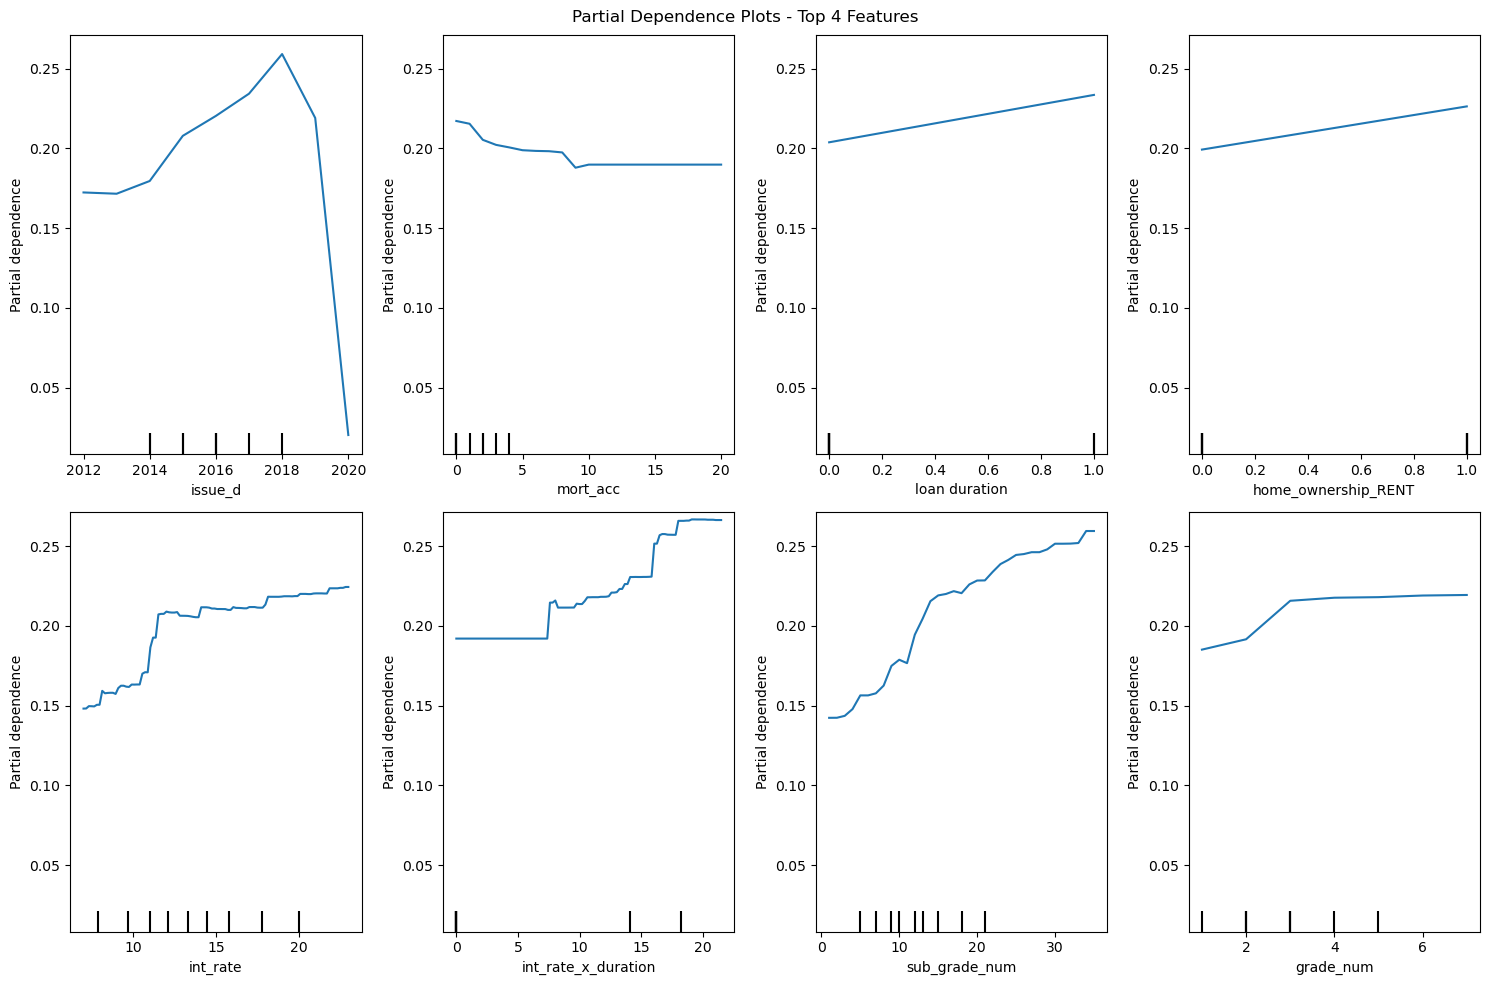

In [75]:
from sklearn.inspection import PartialDependenceDisplay

# Select top 4 most important features for PDP
top_8_features = [feature_names[i] for i in np.argsort(feature_importance)[-8:]]

# Create partial dependence plots
fig, ax = plt.subplots(2, 4, figsize=(15, 10))
PartialDependenceDisplay.from_estimator(
    xgb_model, X_test, 
    features=top_8_features,
    ax=ax.ravel(),
    n_jobs=-1
)
plt.suptitle('Partial Dependence Plots - Top 4 Features')
plt.tight_layout()
plt.show()

## STEP 7

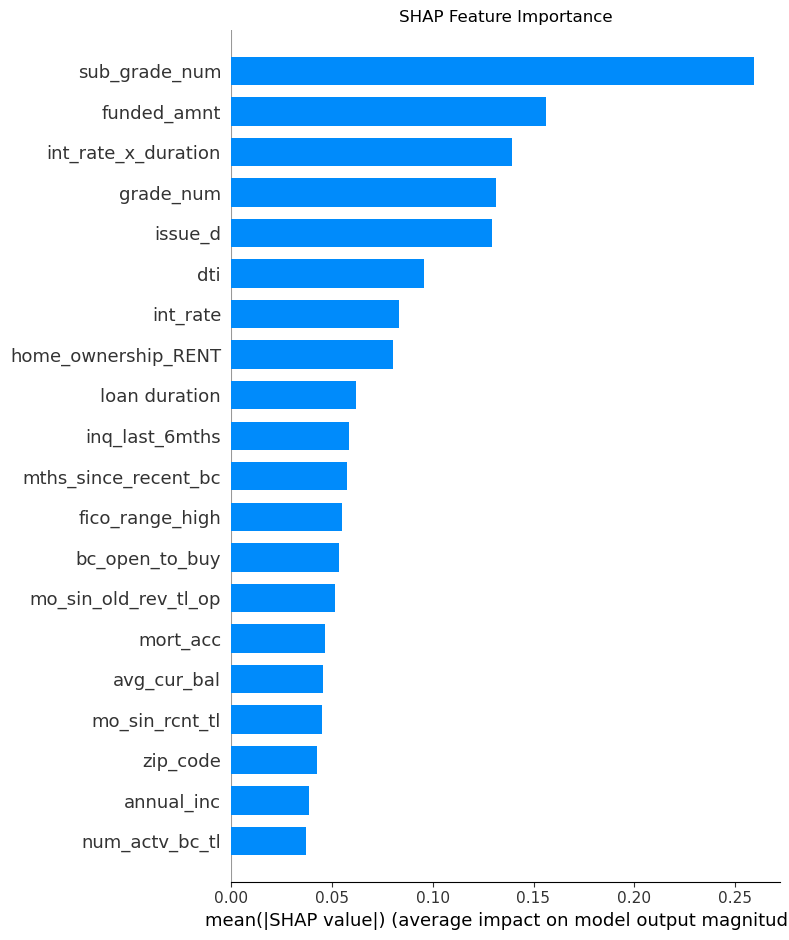

<Figure size 1200x800 with 0 Axes>

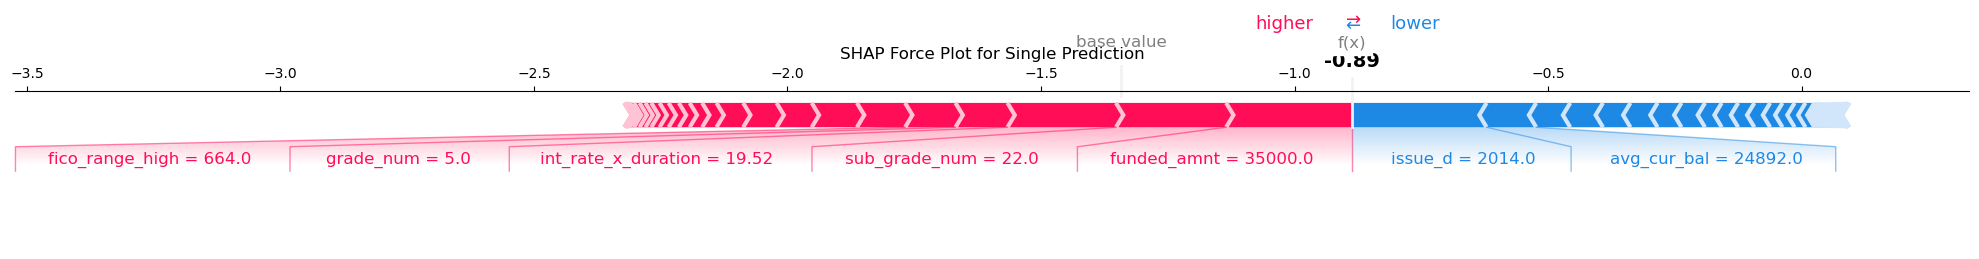

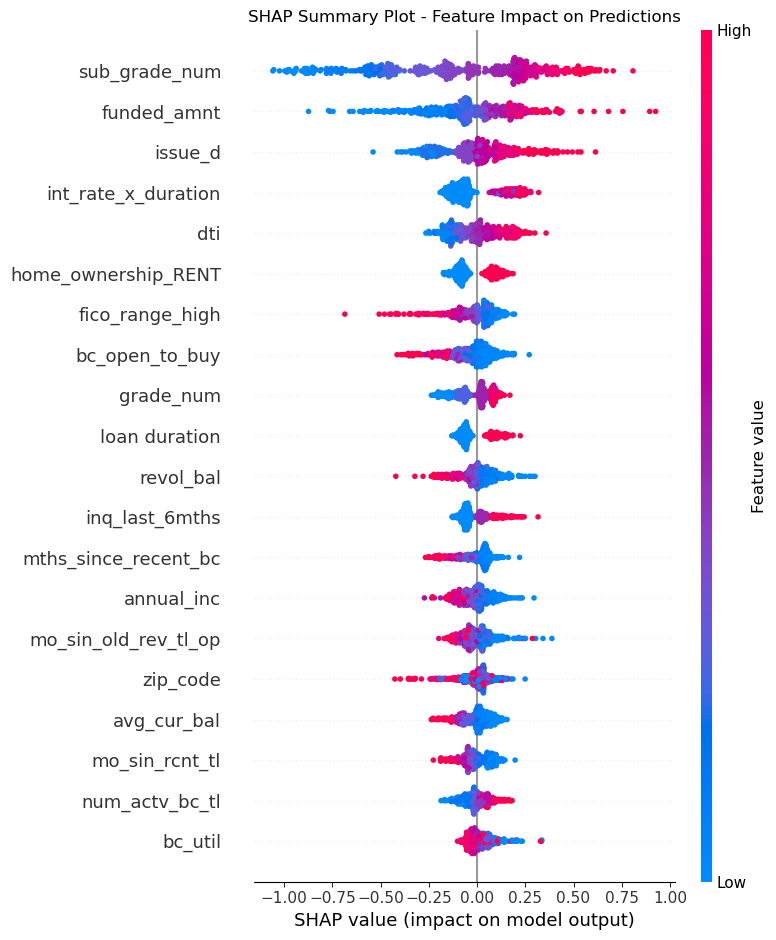

In [76]:
import shap

# Initialize SHAP explainer for XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test[:500])  # Sample 100 instances for speed

# SHAP summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test[:100], plot_type="bar", show=False)
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.show()

# Alternative: SHAP force plot
plt.figure(figsize=(12, 8))
shap.force_plot(explainer.expected_value, shap_values[sample_idx], X_test.iloc[sample_idx], 
                matplotlib=True, show=False)
plt.title('SHAP Force Plot for Single Prediction')
plt.tight_layout()
plt.show()


shap_values = np.array(shap_values, dtype=float)

# 1. SHAP Summary Plot (beeswarm/dot plot)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_clean, X_sample_clean, show=False)
plt.title('SHAP Summary Plot - Feature Impact on Predictions')
plt.tight_layout()
plt.show()
